In [1]:
import os
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Flatten
from keras.layers import Reshape, Lambda, RepeatVector
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU, LSTM
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# model = load_model('cnn-lstm-generated_10c-1.h5')

In [2]:
def CNN_RNN_MODEL(img_h, channel, num_classes):
#     words_per_epoch = 16000
#     val_split = 0.2
#     val_words = int(words_per_epoch * (val_split))

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 128
    rnn_size = 256
    minibatch_size = 32
    act = 'relu'
    img_w = 175
    
    input_shape = (img_w, img_h, channel)
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
    
    conv_to_rnn_dims = (img_w // (pool_size ** 2),
                        (img_h // (pool_size ** 2)) *conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    gru_2 = GRU(rnn_size, return_sequences=False,
                kernel_initializer='he_normal', name='gru2')(inner)
    gru_2b = GRU(rnn_size, return_sequences=False, go_backwards=True,
                 kernel_initializer='he_normal', name='gru2_b')(inner)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    model =  Model(inputs=input_data, outputs=y_pred)
    
    return model

In [3]:
model = CNN_RNN_MODEL(75, 3, 10)
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 175, 75, 3)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 175, 75, 16)  448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 87, 37, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 87, 37, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [5]:
batch_size = 32
train_path = 'iran_shahr/train'
val_path = 'iran_shahr/val'
img_width, img_hight = (175, 75)


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=(img_width, img_hight),  # all images will be resized to 150x150
        batch_size=batch_size, 
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(img_width, img_hight),
        batch_size=batch_size,
        class_mode='categorical')

Found 360 images belonging to 10 classes.
Found 39 images belonging to 10 classes.


In [6]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size)

Epoch 1/50
11/11 [==============================] - 10s 902ms/step - loss: 2.6002 - acc: 0.1080 - val_loss: 2.3075 - val_acc: 0.1875
Epoch 2/50
11/11 [==============================] - 3s 260ms/step - loss: 2.3294 - acc: 0.1214 - val_loss: 2.2622 - val_acc: 0.1429
Epoch 3/50
11/11 [==============================] - 3s 243ms/step - loss: 2.2966 - acc: 0.1307 - val_loss: 2.2745 - val_acc: 0.0938
Epoch 4/50
11/11 [==============================] - 3s 242ms/step - loss: 2.2649 - acc: 0.2165 - val_loss: 2.1042 - val_acc: 0.5714
Epoch 5/50
11/11 [==============================] - 3s 248ms/step - loss: 2.1972 - acc: 0.2222 - val_loss: 2.0846 - val_acc: 0.1875
Epoch 6/50
11/11 [==============================] - 3s 243ms/step - loss: 2.1059 - acc: 0.2407 - val_loss: 1.4311 - val_acc: 0.5714
Epoch 7/50
11/11 [==============================] - 3s 293ms/step - loss: 2.0018 - acc: 0.2287 - val_loss: 1.9641 - val_acc: 0.3125
Epoch 8/50
11/11 [==============================] - 3s 258ms/step - loss: 1

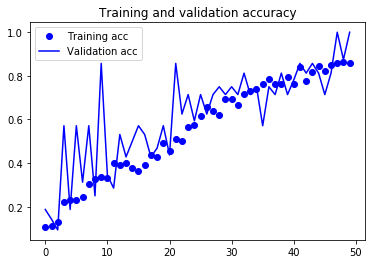

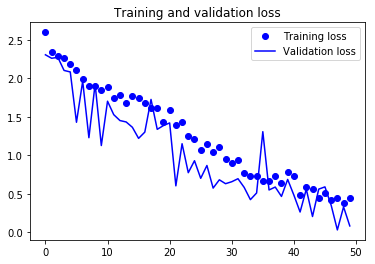

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# infrence

In [8]:
from keras.preprocessing import image

In [9]:
img_path = 'test/1.png'
img = image.load_img(img_path, target_size=(175, 75))
x = image.img_to_array(img)
x /= 255.
x = np.expand_dims(x, axis=0)
print(model.predict(x)[0])
print(np.argmax(model.predict(x)[0]))
# predicted_class = model_dict[str(model.predict_classes(x)[0])]

[3.6700971e-02 7.7572372e-03 8.3157562e-02 8.5508507e-01 1.0649939e-02
 4.4613280e-03 1.8432270e-03 9.8935234e-06 4.3585874e-07 3.3431733e-04]
3


In [10]:
iranshahr_dict = {
    0 : 'آبادان',
    1 : 'آباده',
    2 : 'آبدان',
    3 : 'آبرغان',
    4 : 'آبرومند',
    5 : 'آبریز',
    6 : 'آبعلی',
    7 : 'آبیز',
    8 : 'آبیک',
    9 : 'آذرشهر',
}

In [13]:
import os
path = 'test/'
k = 0
for img in os.listdir(path):
    k += 1
    img2 = image.load_img(path + img, target_size=(175, 75))
    x = image.img_to_array(img2)
    x /= 255.
    x = np.expand_dims(x, axis=0)
#     print(model.predict(x)[0])
#     print(np.argmax(model.predict(x)[0]))
    os.rename(path+img, path+iranshahr_dict[np.argmax(model.predict(x)[0])] + '_' + str(k) + '.png')